In [46]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn
import math
import seaborn as sns
import os

CLEAN AND LOAD DATA


In [ ]:
def load_datasets():
    start_path = "C:/Users/talno/microbiom_project/all_datasets/"
    datasets = [x for x in os.listdir("C:/Users/talno/microbiom_project/all_datasets")]
    all_ibds, all_metas = [], []
    
    for name in datasets:
        subname = name[:-8]
        ibd = pd.read_csv(f'{start_path}{name}/RDP/{subname}.otu_table.100.denovo.rdp_assigned',sep='\t')
        try:
            meta = pd.read_csv(f'{start_path}{name}/{subname}.metadata.txt',sep='\t')
        except:
            meta = pd.read_csv(f'{start_path}{name}/{subname}.metadata.txt',sep='\t', encoding= 'unicode_escape')
        meta.rename(columns={meta.columns[0]: "#SampleID"}, inplace=True)
        all_ibds.append(ibd)
        all_metas.append(meta)
    return all_ibds, all_metas

all_names = [x[:-8] for x in os.listdir("C:/Users/talno/microbiom_project/all_datasets/")]
all_ibds, all_metas = load_datasets()

def clean(meta,ibd,name):
    
    otu = ibd.copy()
    otu["Unnamed: 0"] = otu["Unnamed: 0"].str.split(';', expand=True)[4] + '_' + otu["Unnamed: 0"].str.split(';', expand=True)[5]
    otu = otu.groupby(["Unnamed: 0"]).sum()
    try:
        otu.drop('f___g__', inplace=True)
    except Exception:
        print("no g__, f__")
    otu = otu /otu.sum(axis = 0)
    otu.fillna(0,inplace=True)
    otu = otu.T
    meta.set_index("#SampleID", inplace=True)
    keepsmpls = [i for i in otu.index if i in meta.index]
    otu = otu.loc[keepsmpls]
    meta = meta.loc[keepsmpls]
    otu = otu.join(meta.DiseaseState)
    
    otu.loc[:, "State"] = otu.loc[:, "DiseaseState"].map(
        {"ASD": "D", "nonCDI": "H", "nonIBD": "H", "CD": "D", "UC": "D", "CDI": "D", "H": "H", "postFMT_CDI": "H",
         "ASD": "D", 'HIV': "D", 'EDD': "D", "CRC": 'D', 'OB': "D", 'PAR': "D", "OW": "D", "CIRR": "D", "MHE": "D",
         "nonCRC": "H", "RA": "D", "T1D": "D", "PSA": "H", "nonCDI": "H", "nonCRC": "H", "NASH": "D", "CIRR": "D", "nonNASH-OB": "H"})
    otu["From"] = name
    return otu

fixed = []
for ibd, meta, name in zip(all_ibds, all_metas, all_names):
       fixed.append(clean(meta,ibd,name))
finish_data = pd.concat(fixed)
finish_data.fillna(0,inplace=True)
finish_data.reset_index(drop=True, inplace=True)    
finish_data.to_csv("cleaned_microbiomeHD_29_g")

In [3]:
disease = ["CD","CDI","autism", "RA", "T1D", "CRC", "EDD","HIV", "PAR", "OB", "NASH", "MHE", "ASD"]
disease_map = {"OB": ['ob_goodrich', 'ob_gordon_2008_v2', 'ob_ross', 'ob_zupancic'], "NASH": ['nash_chan', 'nash_ob_baker'], "MHE":['mhe_zhang'], "CD":['ibd_alm','ibd_engstrand_maxee','ibd_gevers_2014','ibd_huttenhower']
               ,"CDI":['cdi_schubert', 'cdi_vincent_v3v5', 'cdi_youngster'],"autism":['autism_kb'], "RA":['ra_littman'],"T1D":['t1d_alkanani','t1d_mejialeon'],"CRC":['crc_baxter', 'crc_xiang', 'crc_zackular', 'crc_zeller', 'crc_zhao'],
               "EDD":['edd_singh'],"HIV":['hiv_dinh', 'hiv_lozupone', 'hiv_noguerajulian'], "PAR": ['par_scheperjans'], "ASD": ['asd_son']}

READ THE CLEANED DATA

-relative abundance 

-microbiome HD is concatenated

-merged with meta data - healthy vs disease


In [36]:
# dataHD = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_microbiomeHD_versionA")
dataHD = pd.read_csv("C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/american_gut/cleaned_microbiomeHD_29_g")
dataAmericans = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_Americans_versionA", low_memory=False)

In [37]:
dataHD.drop(columns='Unnamed: 0', inplace=True)
dataAmericans.drop(columns='Unnamed: 0', inplace=True)

In [38]:
keep_features = [i for i in dataHD.columns if i in dataAmericans.columns]
n = len(keep_features)
print("features left: ", n)

features left:  145


NUMBER OF SAMPLES FROM EACH DATASET

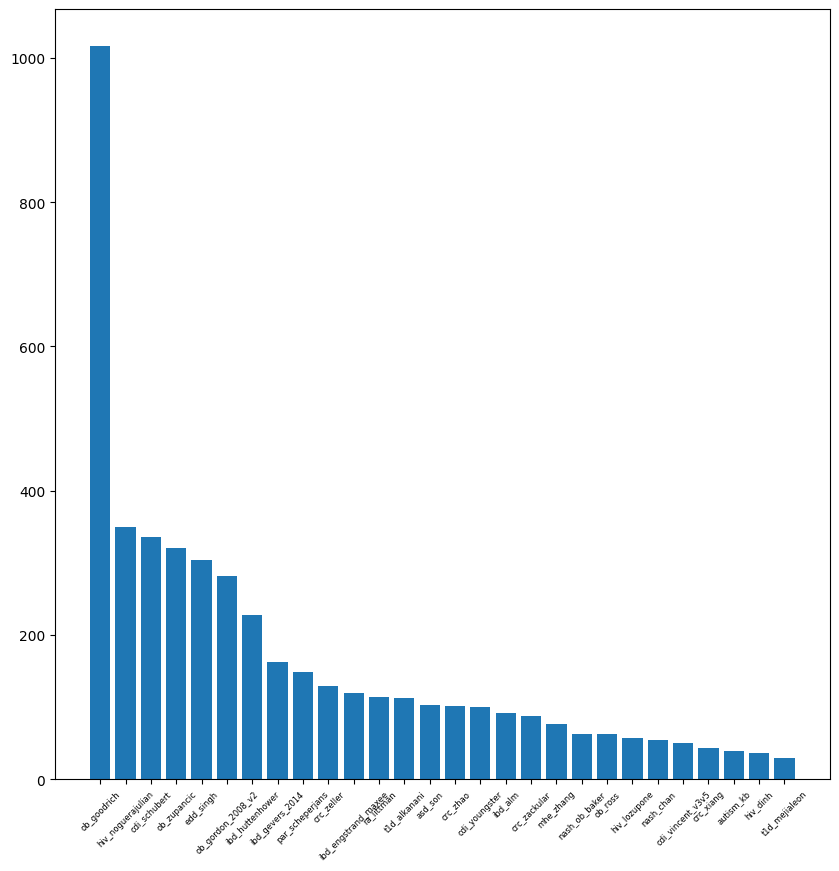

In [117]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(np.arange(0, len(dataHD.From.value_counts())), dataHD.From.value_counts())
plt.xticks(np.arange(0, len(dataHD.From.value_counts())), list(dataHD.From.value_counts().keys()), rotation=45, size=6)
plt.show()
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/samples_number.png')


In [39]:
dataHD_filtered = dataHD.loc[:,keep_features]
dataAmericans_filtered = dataAmericans.loc[:,keep_features]
print("american shape:", dataAmericans_filtered.shape, "microbiomeHD shape: ", dataHD_filtered.shape)


american shape: (9509, 145) microbiomeHD shape:  (4486, 145)


C:\Users\talno\AppData\Local\Temp\ipykernel_20308\743375639.py:3: RuntimeWarning: divide by zero encountered in log
  p1 = seaborn.heatmap(-np.log(dataHD_filtered.values), cmap="Blues", ax=axes[0])
C:\Users\talno\AppData\Local\Temp\ipykernel_20308\743375639.py:4: RuntimeWarning: divide by zero encountered in log
  p2 = seaborn.heatmap(-np.log(dataAmericans_filtered.values), cmap="Blues", ax=axes[1])


Text(0.5, 0.995, '-log heatmap of microbiomeHD vs AmericanGut')

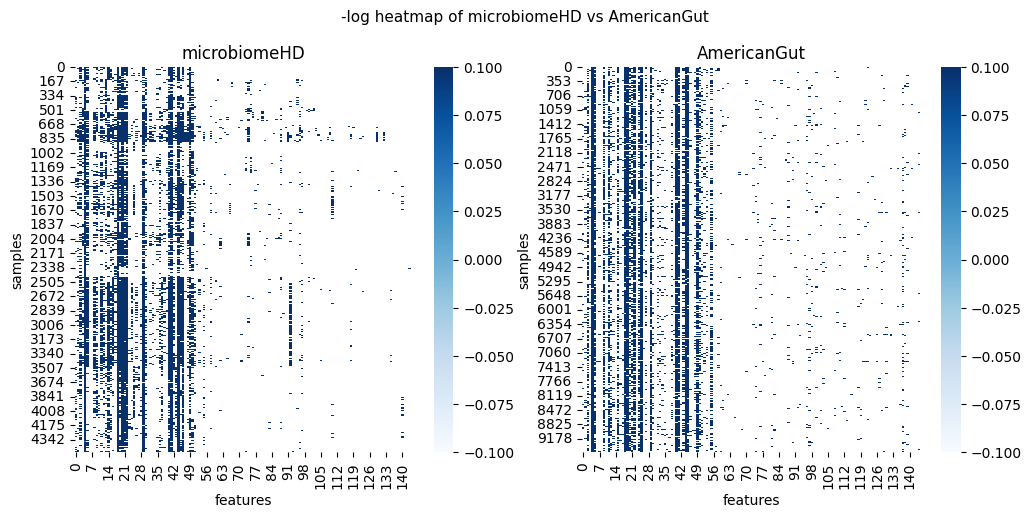

In [40]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
p1 = seaborn.heatmap(-np.log(dataHD_filtered.values), cmap="Blues", ax=axes[0])
p2 = seaborn.heatmap(-np.log(dataAmericans_filtered.values), cmap="Blues", ax=axes[1])

p1.set_xlabel('features')
p1.set_ylabel('samples')
p2.set_xlabel('features')
p2.set_ylabel('samples')

axes[0].set_title("microbiomeHD")
axes[1].set_title("AmericanGut")

fig.suptitle(f"-log heatmap of microbiomeHD vs AmericanGut", x=0.5, y=0.995, fontsize=11)
# plt.show()

C:\Users\talno\AppData\Local\Temp\ipykernel_20308\218723243.py:4: RuntimeWarning: divide by zero encountered in log
  p1 = seaborn.heatmap(-np.log(Healthy.values), cmap="Blues", ax=axes[0])
C:\Users\talno\AppData\Local\Temp\ipykernel_20308\218723243.py:5: RuntimeWarning: divide by zero encountered in log
  p2 = seaborn.heatmap(-np.log(Disease.values), cmap="Blues", ax=axes[1])


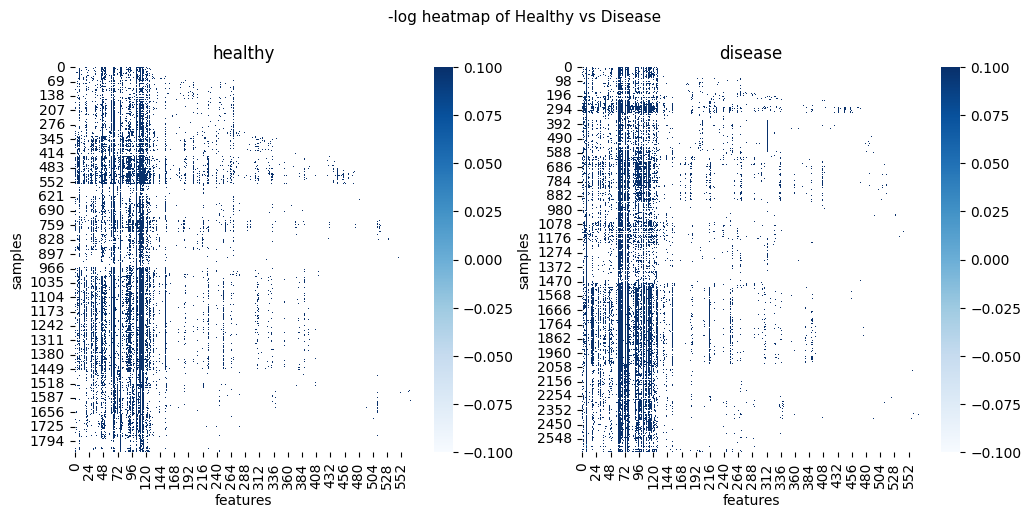

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
Healthy = dataHD.query("State == 'H'").drop(columns=["DiseaseState","State", "From"])
Disease = dataHD.query("State == 'D'").drop(columns=["DiseaseState","State", "From"])
p1 = seaborn.heatmap(-np.log(Healthy.values), cmap="Blues", ax=axes[0])
p2 = seaborn.heatmap(-np.log(Disease.values), cmap="Blues", ax=axes[1])

p1.set_xlabel('features')
p1.set_ylabel('samples')
p2.set_xlabel('features')
p2.set_ylabel('samples')

axes[0].set_title("healthy")
axes[1].set_title("disease")

fig.suptitle(f"-log heatmap of Healthy vs Disease", x=0.5, y=0.995, fontsize=11)
plt.show()



After dropping features- whats left...

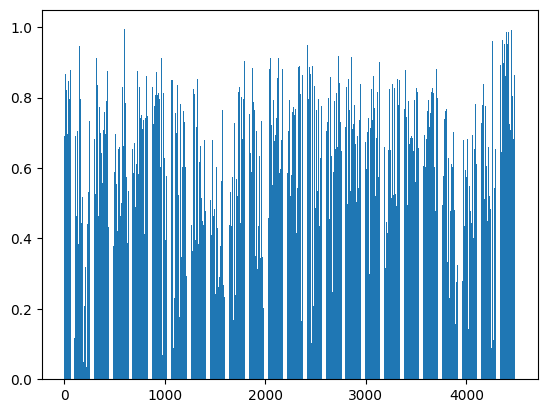

In [14]:
%matplotlib inline
plt.bar(np.arange(0, len(dataHD_filtered)), list(dataHD_filtered.sum(axis=1)))
plt.show()


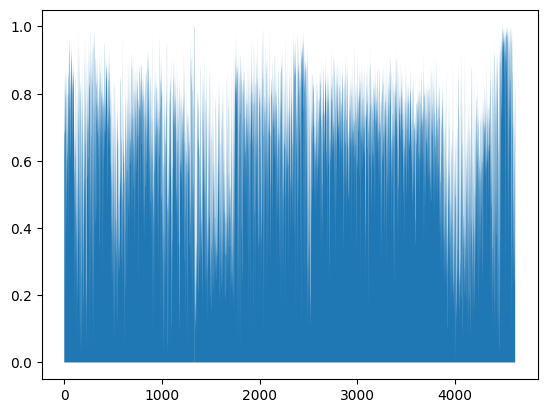

In [122]:
from scipy.interpolate import make_interp_spline, BSpline

#create data
x = np.arange(0, len(dataHD_filtered))
y = np.array(list(dataHD_filtered.sum(axis=1)))

plt.fill_between(x, y,0, alpha=1)
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/Remaining_percentage_after_filter2.png')


In [42]:
dataHD_filtered['From'] = dataHD['From']

In [43]:
dataAmericans_filtered['From'] = 'americans'

In [44]:
all_data = pd.concat([dataHD_filtered, dataAmericans_filtered]).reset_index(drop=True)

PCoA FOR THE BIG DATA (AmericanGut + microbiomeHD)

In [126]:
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
bc_dm = beta_diversity("braycurtis", all_data, list(all_data.index))
bc_pc = pcoa(bc_dm)

c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -38.82456232723804 and the largest is 731.3111358040362.
  warn(


In [ ]:
pcoa_comp = bc_pc.samples.loc[:4616, ['PC1'	,'PC2']]

c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\skbio\stats\ordination\_ordination_results.py:285: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


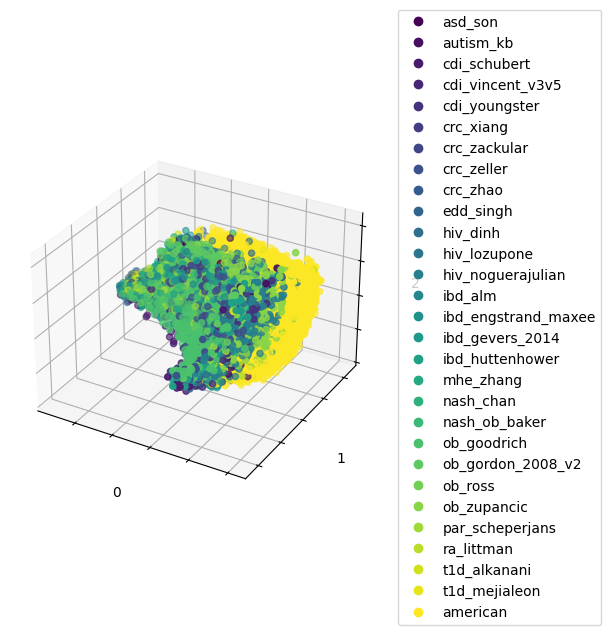

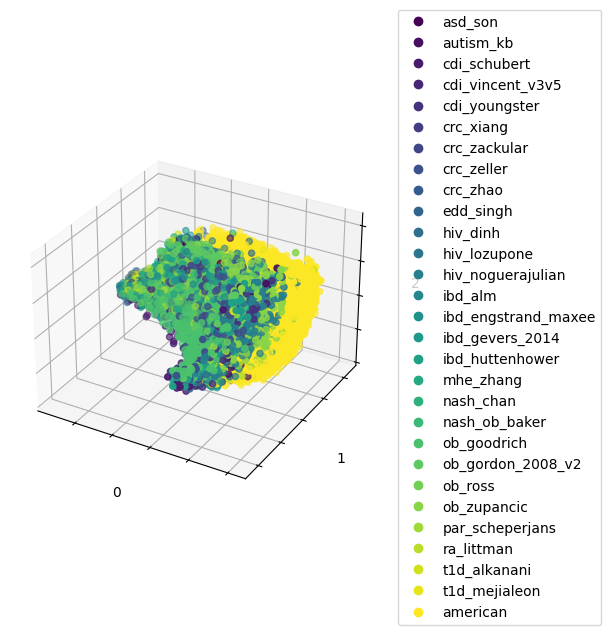

In [ ]:
bc_pc.plot(df=all_data, column='From')

In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
distance_table = pd.DataFrame(pairwise_distances(all_data, metric="braycurtis"), index=all_data.index,
                                      columns=all_data.index)
mod = MDS(n_components=2, dissimilarity="precomputed")
components = mod.fit_transform(distance_table)


In [ ]:
bc_pc.proportion_explained[:2]*100

PC1    15.236922
PC2     9.276083
dtype: float64

In [ ]:
colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'b', 'g']

In [ ]:
def plot_by(name):
    for disease, color in zip(dataHD[name].unique(), colors):
        plt.scatter(pcoa_comp.loc[dataHD[dataHD[name] == disease].index,'PC1'], pcoa_comp.loc[dataHD[dataHD[name] == disease].index,'PC2'],marker='o',s=10, color= color)
    plt.legend(dataHD[name].unique(), bbox_to_anchor=(1, 0., 0.5, 0.5))


In [ ]:
np.logical_and(dataHD['DiseaseState'] == 'OB', dataHD['State'] == 'H')

0       False
1       False
2       False
3       False
4       False
        ...  
4612    False
4613    False
4614    False
4615    False
4616    False
Length: 4614, dtype: bool

In [ ]:
dataHD[dataHD['DiseaseState'] == 'OB' & dataHD['State'] == 'H')].index

TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]

In [ ]:
def plot_by():
    for disease, color in zip(dataHD['From'].unique(), colors):
        plt.scatter(pcoa_comp.loc[(dataHD[np.logical_and(dataHD['From'] == disease,dataHD['State'] == 'H')]).index,'PC1'], pcoa_comp.loc[(dataHD[np.logical_and(dataHD['From'] == disease ,dataHD['State'] == 'H')]).index,'PC2'],c='none',marker='o',s=15, edgecolor= color)
        plt.scatter(pcoa_comp.loc[(dataHD[np.logical_and(dataHD['From'] == disease,dataHD['State'] == 'D')]).index,'PC1'], pcoa_comp.loc[(dataHD[np.logical_and(dataHD['From'] == disease, dataHD['State'] == 'D')]).index,'PC2'],c= color, marker='o',s=15, edgecolor= color)
    plt.legend(dataHD['From'].unique(), bbox_to_anchor=(1, 0., 0.5, 0.5))

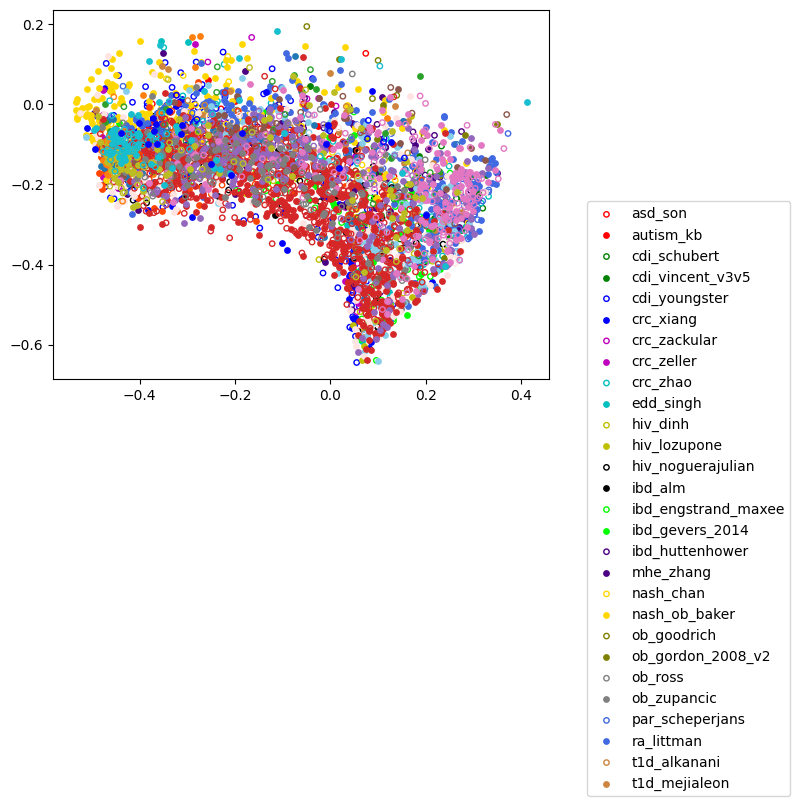

In [ ]:
plot_by()

PCA- fit both data

In [131]:
pca = PCA(n_components=2)
pca.fit(dataAmericans_filtered)
components_americans1 = pca.transform(dataAmericans_filtered)
components_HD1 = pca.transform(dataHD_filtered)
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_americans1 = pd.DataFrame(data= components_americans1, columns= ['Pc1', 'Pc2'])
pca_HD1 = pd.DataFrame(data= components_HD1, columns= ['Pc1', 'Pc2'])


explained variance:  0.5197981346936754


In [129]:
pcoa_comp.values

array([[-0.30383295, -0.12888126],
       [-0.43173961, -0.12832124],
       [-0.29386612, -0.13932133],
       ...,
       [-0.00972679, -0.09932029],
       [-0.49350267, -0.11202636],
       [-0.31246584, -0.07523143]])

In [130]:
pca_HD3 = pd.DataFrame(data= pcoa_comp.values, columns= ['Pc1', 'Pc2'])

PCA- fit only american

In [ ]:
pca = PCA(n_components=2)
pca.fit(all_data)
components_americans2 = pca.transform(dataAmericans_filtered)
components_HD2 = pca.transform(dataHD_filtered)
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_americans2 = pd.DataFrame(data= components_americans2, columns= ['Pc1', 'Pc2'])
pca_HD2 = pd.DataFrame(data= components_HD2, columns= ['Pc1', 'Pc2'])

ValueError: could not convert string to float: 'asd_son'

PCA- all data vs only american's

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
axes[1].scatter(pca_americans2.loc[:,'Pc1'], pca_americans2.loc[:,'Pc2'],marker='.',s=2, color= 'g')
fig.tight_layout()
plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/americans_pca_vs_all_pca.png')
plt.show()

In [ ]:
disease_map

C:\Users\talno\AppData\Local\Temp\ipykernel_25100\152276615.py:21: RuntimeWarning: Mean of empty slice.
  x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\talno\AppData\Local\Temp\ipykernel_25100\152276615.py:22: RuntimeWarning: Mean of empty slice.
  y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\talno\AppData\Loca

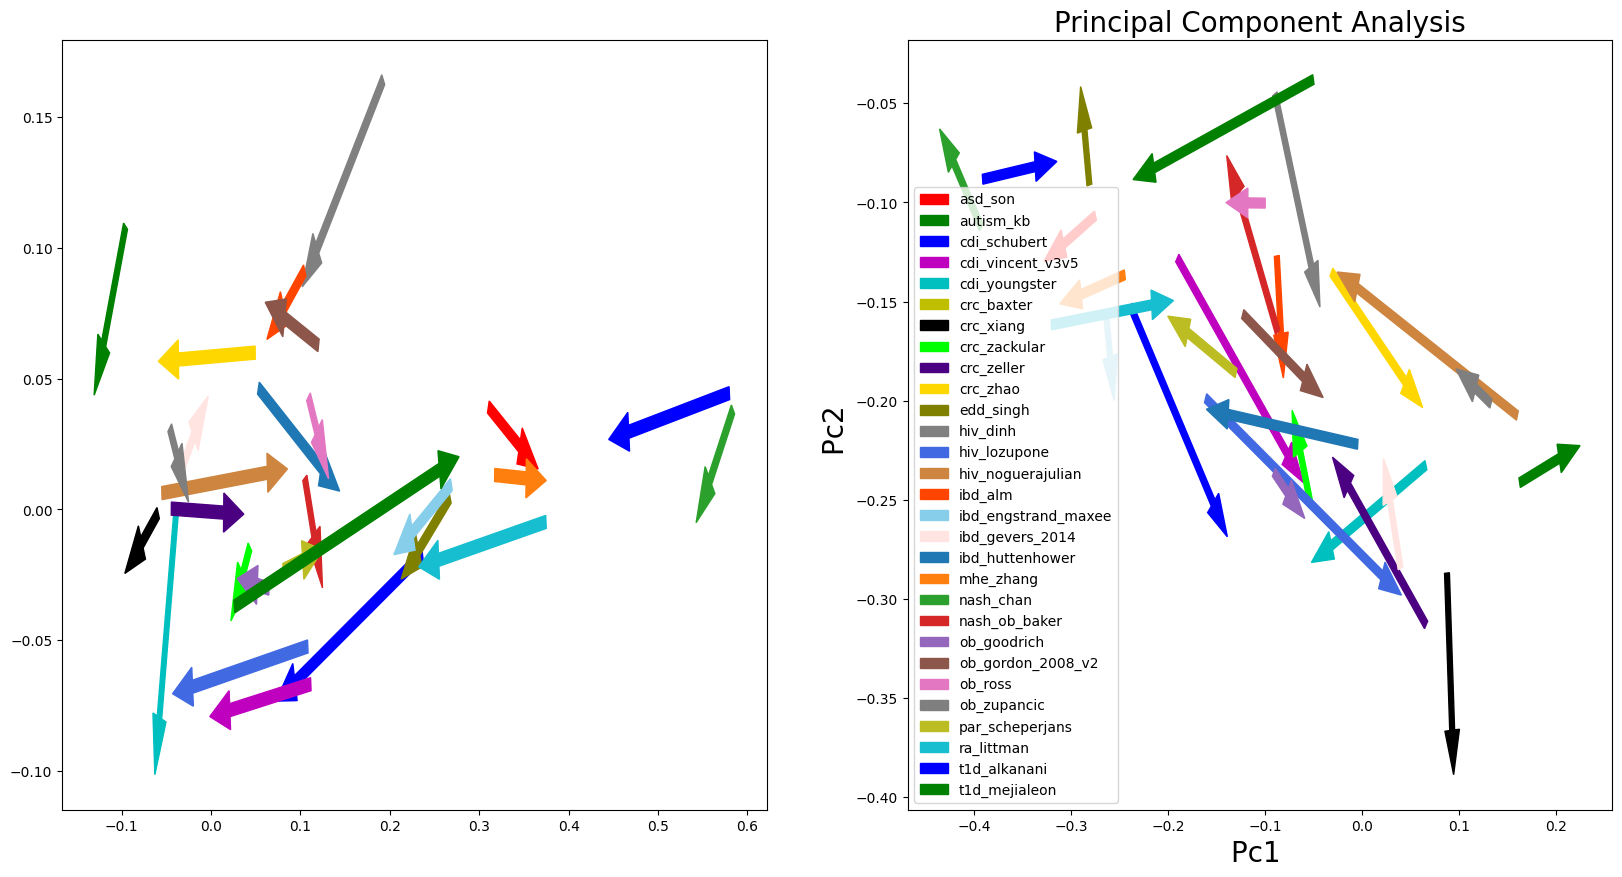

In [132]:
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
itr = [pca_HD1, pca_HD3]
polar_data = dict()
for i, pca_HD in enumerate(itr):
    plt.xlabel('Pc1 ', fontsize=20)
    plt.ylabel('Pc2 ', fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = np.array([[[name, 'H'], [name,'D']] for name in all_names])
    targets = targets.reshape((-1,2))
    # targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
    colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose', '#1f77b4','#1f77b4','#ff7f0e', '#ff7f0e','#2ca02c', '#2ca02c','#d62728', '#d62728','#9467bd', '#9467bd', '#8c564b','#8c564b','#e377c2', '#e377c2', '#7f7f7f','#7f7f7f','#bcbd22', '#bcbd22', '#17becf','#17becf', 'b', 'b', 'g', 'g']
    arrows, var_x, var_y, angles, sizes = [], [], [], [], []
    # axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
    for target, color in zip(targets,colors):
        indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['State'] == target[1])
        fill = 'none'
        if target[1] == "D":
            fill = color
        x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
        x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
        y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
        var_x.append(x_v)
        var_y.append(y_v)
        arrows.append(x)
        arrows.append(y)
        # axes[i].scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
    # find centroids and plotting an arrow
    col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'b', 'g']
    for j in range(0,len(arrows),4):
        axes[i].arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4], width = 0.005)
        angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
        sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
    plt.legend(all_names) 
    polar_data[i] = [var_x, var_y, angles, sizes]
# fig.show()

In [133]:
def pca_disease(disease):
    arrows = []
    lst = disease_map[disease] + ['None']*(5-len(disease))
    data_partial = dataHD[(dataHD['From'] == lst[0]) | (dataHD['From'] == lst[1]) | (dataHD['From'] == lst[2]) | (dataHD['From'] == lst[3]) | (dataHD['From'] == lst[4])]
    keep_features = [i for i in data_partial.columns if i in dataAmericans.columns and data_partial[i].sum() > 0.1] 
    print(len(keep_features))  
    data_filtered = data_partial.loc[:,keep_features]
    dataAmericans_filtered = dataAmericans.loc[:,keep_features]     
    pca = PCA(n_components=2)
    pca.fit(pd.concat([dataAmericans_filtered, data_filtered]))
    components_americans = pca.transform(dataAmericans_filtered)
    components_disease = pca.transform(data_filtered)
    print("explained variance: ", sum(pca.explained_variance_ratio_))
    pca_americans = pd.DataFrame(data= components_americans, columns= ['Pc1', 'Pc2'])
    pca_disease = pd.DataFrame(data= components_disease, columns= ['Pc1', 'Pc2'])  
    
    plt.xlabel('Pc1 ', fontsize=10)
    plt.ylabel('Pc2 ', fontsize=10)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = lst
    colors = ['r','c', 'b','lime']
    for target, color in zip(targets,colors):
        indicesToKeep = (data_partial['From'] == target) & (data_partial['State'] == 'H')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        # plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c=color, edgecolors=color, s=50)
        indicesToKeep = (data_partial['From'] == target) & (data_partial['State'] == 'D')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        # plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c='none', edgecolors=color, s=50)
    
    # find centroids and plotting an arrow
    col = ['r', 'c', 'b', 'lime']
    for j in range(0,len(arrows),4):
        plt.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4], width = 0.01)
    plt.legend(targets) 
    # fig.show() 

                              

In [ ]:
pca_disease("OB")

In [135]:
disease = ["CD","CDI","autism", "RA", "T1D", "CRC", "EDD","HIV", "PAR", "OB", "NASH", "MHE", "ASD"]
disease_map = {"OB": ['ob_goodrich', 'ob_gordon_2008_v2', 'ob_ross', 'ob_zupancic'], "NASH": ['nash_chan', 'nash_ob_baker'], "MHE":['mhe_zhang'], "CD":['ibd_alm','ibd_engstrand_maxee','ibd_gevers_2014','ibd_huttenhower']
               ,"CDI":['cdi_schubert', 'cdi_vincent_v3v5', 'cdi_youngster'],"autism":['autism_kb'], "RA":['ra_littman'],"T1D":['t1d_alkanani','t1d_mejialeon'],"CRC":['crc_baxter', 'crc_xiang', 'crc_zackular', 'crc_zeller', 'crc_zhao'],
               "EDD":['edd_singh'],"HIV":['hiv_dinh', 'hiv_lozupone', 'hiv_noguerajulian'], "PAR": ['par_scheperjans'], "ASD": ['asd_son']}
data_map = dict()
for key, vals in disease_map.items():
    for val in vals:
        data_map[val] = key

In [ ]:
data_map

POLAR PLOT

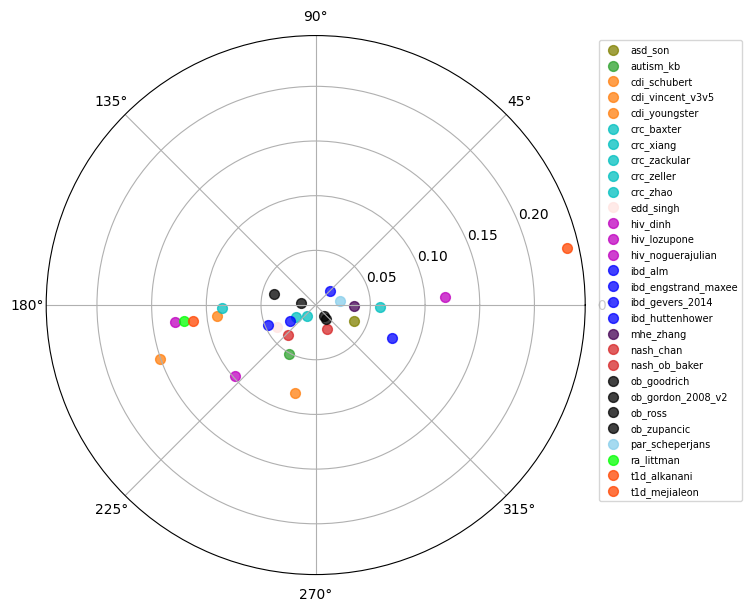

In [137]:
from matplotlib.patches import Ellipse
# 'skyblue','mistyrose', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'b', 'g']
color_disease = {"CD": 'b', "CDI": '#ff7f0e', "autism": '#2ca02c', "OB": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime', "EDD": 'mistyrose', "PAR": 'skyblue', "NASH": '#d62728', "MHE": y, "ASD":'olive'}
var_x, var_y, angles, sizes = polar_data[0]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
for angle,name,size in zip(angles,all_names,sizes):
    # ax.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    c = ax.scatter(angle, size, c=color_disease[data_map[name]], alpha=0.75, s=50)
    # c = ax.scatter(angle, size, c=color, alpha=0.75, s=50)
plt.legend(all_names,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

Now only for the microbiomeHD PCA.

In [ ]:
pca = PCA(n_components=2)
components_HD = pca.fit_transform(dataHD.drop(columns=['DiseaseState', 'From', 'State']))
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_HD = pd.DataFrame(data= components_HD, columns= ['Pc1', 'Pc2'])

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)
# plt.xlabel('Pc1 ', fontsize=20)
# plt.ylabel('Pc2 ', fontsize=20)
# plt.title("Principal Component Analysis",fontsize=20)
# targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]

colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
arrows, var_x, var_y, angles, sizes = [], [], [], [], []
# axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
for target, color in zip(targets,colors):
    indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['State'] == target[1])
    fill = 'none'
    if target[1] == "D":
        fill = color
    x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
    y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
    x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
    y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
    var_x.append(x_v)
    var_y.append(y_v)
    arrows.append(x)
    arrows.append(y)
    # axes[0].scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
# find centroids and plotting an arrow
col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
for j in range(0,len(arrows),4):
    ax1.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4],width = 0.01)
    angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
    sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
plt.legend(L) 

colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]

for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    # ax2.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax2.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    c = ax2.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=50)
    # c = ax2.scatter(angle, size, c=color, alpha=0.75, s=50)
ax2.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

STATISTICS

In [ ]:
new_df = pd.DataFrame({'angles': np.rad2deg(angles), 'length': sizes, 'names': np.array(L)[:,0], 'disease': np.array(L)[:,1]})

In [ ]:
mat = [[0 for i in range(len(angles))] for j in range(len(angles))]
disease = ["CD","CDI","autism", "Obese", "RA","T1D","CRC","EDD","HIV"]
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]
helper = {"CD":[0,1],"CDI":[2,3,4],"autism":[5,6], "Obese":[7], "RA":[8],"T1D":[9],"CRC":[10,11,12,13],"EDD":[14],"HIV":[15,16]}
angles1 = np.rad2deg(angles)
n = len(disease)
for i in range(len(angles1)):
    for j in range(i,len(angles1)):
        diff = min(abs(angles1[i]-angles1[j]),360-abs(angles1[i]-angles1[j]))
        mat[i][j] = math.cos(math.radians(diff))
        mat[j][i] = mat[i][j]

mat_disease = [[0]*n for i in range(n)]
for i in range(n):
    for key,vals in helper.items():
        idx = disease.index(key)
        for val in vals:
            for x in helper[disease[i]]:
                mat_disease[i][idx] += mat[x][val]
        mat_disease[i][idx] /= len(vals)*len(helper[disease[i]])

plt.figure()
plt.title('Disease Similarity matrix',fontsize=20)
plt.title('Direction similarity')
plt.xticks(range(n), disease, rotation=90)
plt.yticks(range(n), disease)
plot = seaborn.heatmap(mat,xticklabels=L, yticklabels=L,cmap="crest")
plt.show()

In [ ]:

new_df['similarity'] = mat
new_df['similarity'] = [np.delete(new_df['similarity'][i], i) for i in range(17)]
new_df['pred'] = [np.delete(np.array((new_df['disease'] == new_df['disease'][i]).values*1),i) for i in range(17)]
indexes = [i for i in range(17) if i not in [7,8,9,14]]
new_df.loc[indexes,'different_disease'] = [sum((new_df['similarity'][i][new_df['pred'][i] == 0]))/len(new_df['similarity'][i][new_df['pred'][i] == 0]) for i in indexes]
new_df.loc[indexes,'same_disease'] = [sum((new_df['similarity'][i][new_df['pred'][i] == 1]))/len(new_df['similarity'][i][new_df['pred'][i] == 1]) for i in indexes]

In [ ]:
new_df.head(3)

In [ ]:
n= len(indexes)
r = np.arange(n)
width = 0.4
  
  
plt.bar(r, new_df.loc[indexes,'same_disease'], color = 'magenta',
        width = width, edgecolor = 'black',
        label='same_D_av')
plt.bar(r + width, new_df.loc[indexes, 'different_disease'], color = 'grey',
        width = width, edgecolor = 'black',
        label='Diff_D_av')
  
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,new_df.loc[indexes,'disease'], size=7)
plt.legend()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

y_pred = np.asarray(list(np.stack(new_df['similarity'].values).reshape(-1)))
y_true = np.asarray(list(np.stack(new_df['pred'].values).reshape(-1)))
fpr, tpr, thresholds = roc_curve(y_true,y_pred)
plt.plot(fpr,tpr,label="fpr->tpr, auc="+str(metrics.auc(fpr, tpr)))
print("auc: ", metrics.auc(fpr, tpr))
plt.legend(fontsize=10)

In [ ]:
dataHD = dataHD.query('DiseaseState != "0"')
dataHD.DiseaseState.value_counts()

In [ ]:
pca = PCA(n_components=2)
components_HD = pca.fit_transform(dataHD.query('DiseaseState != 0').drop(columns=['DiseaseState', 'From']))
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_HD = pd.DataFrame(data= components_HD, columns= ['Pc1', 'Pc2'])
pca_HD['Cluster'] = dataHD.query('DiseaseState != 0').DiseaseState

sns.lmplot( x="Pc1", y="Pc2",
data=pca_HD, 
fit_reg=False, 
hue='Cluster', # color by cluster
legend=True,
scatter_kws={"s": 80}) 


In [ ]:
from sklearn.manifold import TSNE
# tsne = TSNE(metric = 'braycurtis', perplexity=30.0)
tsne = TSNE(metric = 'jaccard', perplexity=30.0)
embeddings = tsne.fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
# embeddings = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
pca_HD_e = pd.DataFrame(data = embeddings, columns = ['Pc1', 'Pc2'])

In [ ]:
import sklearn
sorted(sklearn.neighbors.VALID_METRICS['brute'])

In [ ]:

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)

targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
arrows, var_x, var_y, angles, sizes = [], [], [], [], []
# axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
for target, color in zip(targets,colors):
    indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['DiseaseState'] == target[1])
    fill = 'none'
    if target[1] == "D":
        # color = 'r'
        fill = color
    # else:
        # color = 'k'
    x = pca_HD_e.loc[indicesToKeep.values, 'Pc1'].values.mean()
    y = pca_HD_e.loc[indicesToKeep.values, 'Pc2'].values.mean()
    x_v = np.var(pca_HD_e.loc[indicesToKeep.values, 'Pc1'].values)
    y_v = np.var(pca_HD_e.loc[indicesToKeep.values, 'Pc2'].values)
    var_x.append(x_v)
    var_y.append(y_v)
    arrows.append(x)
    arrows.append(y)
    # if target[0] == 'schubert':
    ax1.scatter(pca_HD_e.loc[indicesToKeep.values, 'Pc1'] , pca_HD_e.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)

# find centroids and plotting an arrow
col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
for j in range(0,len(arrows),4):
    ax1.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4], width = 0.5)
    angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
    sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
plt.legend(L) 

colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]

for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    # ax2.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax2.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    # size = 0.04
    c = ax2.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=70)
    # c = ax2.scatter(angle, size, c=color, alpha=0.75, s=50)
ax1.legend(targets,prop={'size': 7}, bbox_to_anchor=(0.7, 1))
ax2.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

Bray-Curtis: Bray-Curtis is a widely used distance metric in microbiome analysis. It accounts for the relative abundance of taxa and is not affected by differences in overall sequencing depth. It is generally good for comparing community composition across different samples and habitats.

Jaccard: Jaccard is a binary distance metric that only considers the presence or absence of microbial taxa in a community. It is good for comparing the similarity of microbial communities based on their shared taxa.

